<a href="https://colab.research.google.com/github/Krishnaugale353/FaultFindy/blob/main/Tyres.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

krishnaugale_tyres_data_path = kagglehub.dataset_download('krishnaugale/tyres-data')

print('Data source import complete.')


In [ ]:
from pathlib import Path

# Set dataset path
dataset_path = Path("/kaggle/input/tyres-data/Digital images of defective and good condition tyres")
CLR = "\n"  # Corrected newline character

# Set paths for defective and good tyres
defective_path = dataset_path / "defective"
good_path = dataset_path / "good"

# Count the number of files
defect_size = len(list(defective_path.glob("*")))  # Get all files in 'defective' folder
good_size = len(list(good_path.glob("*")))  # Get all files in 'good' folder

# Print the results
print(CLR + "Number of defective tyre images:".ljust(35), f"{defect_size}")
print(CLR + "Number of good tyre images:".ljust(35), f"{good_size}")
total_size = defect_size + good_size



Number of defective tyre images:    1028

Number of good tyre images:         828


In [ ]:
import plotly.express as px

# Calculate percentages
defect_percentage = defect_size / total_size * 100
good_percentage = good_size / total_size * 100

# Create bar chart
fig = px.bar(
    x=[defect_percentage, good_percentage],
    y=["Defective", "Good"],
    text_auto=".1f",  # Display percentages on bars with one decimal
    title="Tyres Quality - Binary Target to Classify<br>"
    "<span style='font-size: 75%; font-weight: bold;'>"
    "Slight imbalance but still reasonable enough</span>",
    color_discrete_sequence=["#4A4B52"],
    height=280,
    width=840,
)

# Customize axes
fig.update_xaxes(title="Percent Count", range=(-2, 100))
fig.update_yaxes(title="", categoryorder="total ascending")

# Customize traces and layout
fig.update_traces(textposition="outside")
fig.update_layout(
    font_color="black",  # Set font color
    title_font_size=18,
    plot_bgcolor="white",  # Set plot background color
    paper_bgcolor="white",  # Set paper background color
    xaxis_showgrid=False,
    yaxis_showgrid=False,
    bargap=0.4,
)

# Show the plot
fig.show()


In [ ]:
import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Print CLR if needed (this is probably for console formatting)
print(CLR, end="")

# Load the dataset using Keras
inefficient_dataset = image_dataset_from_directory(
    dataset_path,
    class_names=("defective", "good"),  # Classes corresponding to the subfolders
    batch_size=32,  # Number of images per batch
    image_size=(224, 224),  # Resize images to 224x224 pixels
    shuffle=True,  # Shuffle the dataset
    seed=42,  # Random seed for reproducibility
    crop_to_aspect_ratio=True,  # Crop images to maintain aspect ratio
)

# You can now use `inefficient_dataset` for training a model



Found 1856 files belonging to 2 classes.



Several Image Examples:


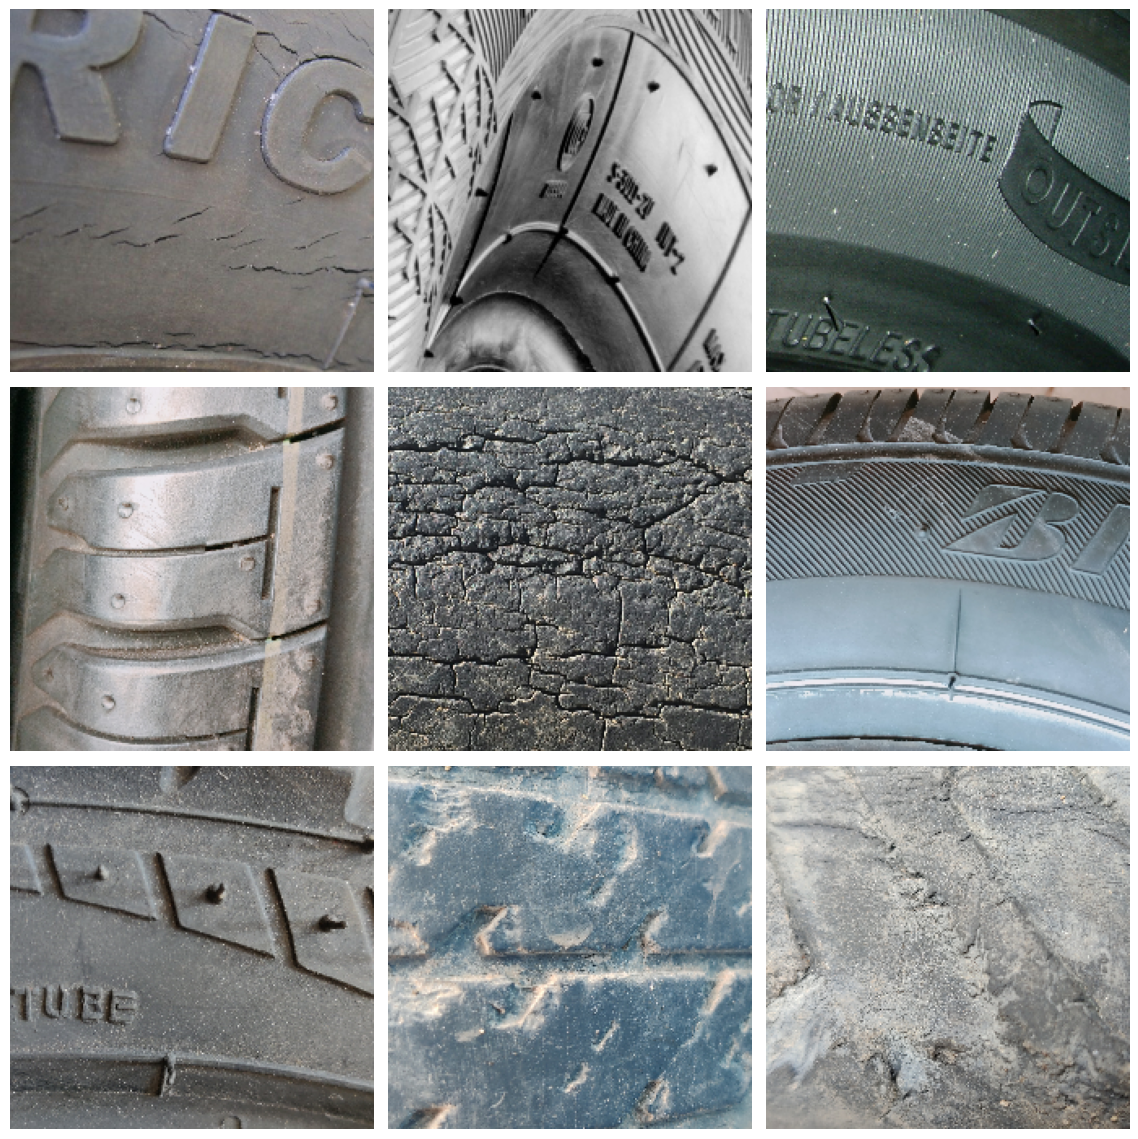

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Print CLR if needed (this is probably for console formatting)
print(CLR + "Several Image Examples:")

# Get one batch of images and labels
images, labels = list(inefficient_dataset.take(1).as_numpy_iterator())[0]

# Plot the first 9 images from the batch
plt.figure(figsize=(11.5, 11.5), tight_layout=True, facecolor="white")
for idx, (image, label) in enumerate(zip(images[:9], labels[:9]), start=1):
    plt.subplot(3, 3, idx)  # 3x3 grid
    plt.imshow(image.astype(np.int32))  # Convert image to int32 for proper display
    plt.axis("off")  # Hide the axis

# Show the images
plt.show()


In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

# Define AUTOTUNE
AUTOTUNE = tf.data.AUTOTUNE

# Prefetch the dataset for performance optimization
inefficient_dataset = inefficient_dataset.prefetch(buffer_size=AUTOTUNE)

# Optionally, benchmark by measuring time it takes to iterate through the dataset
import time

start_time = time.time()
for _ in inefficient_dataset.take(5):  # Iterate over a few batches to benchmark
    pass
end_time = time.time()

# Print the time it took to iterate
print(f"Benchmark: {end_time - start_time} seconds for 5 batches.")


Benchmark: 2.6023480892181396 seconds for 5 batches.


In [ ]:
import tensorflow as tf

def serialize_images_to_tfrecord(
    image_paths, labels, filename, /, size=(224, 224), compression="GZIP"
):
    height, width = size
    options = tf.io.TFRecordOptions(compression_type=compression)
    resizing = tf.keras.layers.Resizing(height=height, width=width, crop_to_aspect_ratio=True)

    with tf.io.TFRecordWriter(filename, options) as writer:
        for image_path, label in zip(image_paths, labels):
            # Read and decode the image
            image = tf.io.decode_jpeg(tf.io.read_file(image_path), channels=3)
            image_resized = tf.cast(resizing(image), dtype=tf.uint8)
            image_encoded = tf.io.encode_jpeg(image_resized)

            # Create a feature map to store in TFRecord
            feature = {
                "image": tf.train.Feature(
                    bytes_list=tf.train.BytesList(value=[image_encoded.numpy()])
                ),
                "label": tf.train.Feature(
                    int64_list=tf.train.Int64List(value=[label])
                ),
            }

            # Create an Example protocol buffer and serialize it
            example = tf.train.Example(features=tf.train.Features(feature=feature))
            writer.write(example.SerializeToString())

# Example usage:
# serialize_images_to_tfrecord(image_paths, labels, "output.tfrecord")


In [ ]:
import glob
import numpy as np
from sklearn.model_selection import train_test_split
from pathlib import Path

def get_train_valid_subsets(data_path, /, valid_ratio=0.2, seed=None):
    # Ensure data_path is a Path object
    data_path = Path(data_path)

    # Get the paths to defective and good images
    defective_paths = glob.glob(str(data_path / "defective" / "*"))
    good_paths = glob.glob(str(data_path / "good" / "*"))

    # Combine paths of both classes (defective and good)
    paths = np.concatenate((defective_paths, good_paths))

    # Create labels for each class: 0 for defective and 1 for good
    defective_labels = [0] * len(defective_paths)
    good_labels = [1] * len(good_paths)
    labels = np.concatenate((defective_labels, good_labels))

    # Split the paths and labels into training and validation sets
    return train_test_split(
        paths, labels, test_size=valid_ratio, random_state=seed, stratify=labels
    )


In [ ]:
train_paths, valid_paths, train_labels, valid_labels = get_train_valid_subsets(
    dataset_path, valid_ratio=0.125, seed=42
)

print(CLR + "Training Image Paths:\n")
print(train_paths[:3])
print("\nTraining Labels:", train_labels[:3])



Training Image Paths:

['/kaggle/input/tyres-data/Digital images of defective and good condition tyres/defective/Defective (861).jpg'
 '/kaggle/input/tyres-data/Digital images of defective and good condition tyres/good/good (506).jpg'
 '/kaggle/input/tyres-data/Digital images of defective and good condition tyres/defective/Defective (126).jpg']

Training Labels: [0 1 0]


In [ ]:
# Serialize the training and validation image paths and labels to TFRecord files
serialize_images_to_tfrecord(train_paths, train_labels, "train.tfrecord")
serialize_images_to_tfrecord(valid_paths, valid_labels, "valid.tfrecord")


In [ ]:
def parse_example(serialized_example, /):
    feature_descr = {
        "image": tf.io.VarLenFeature(dtype=tf.string),
        "label": tf.io.FixedLenFeature(shape=[1], dtype=tf.int64),
    }
    example = tf.io.parse_single_example(serialized_example, feature_descr)
    return tf.io.decode_jpeg(example["image"].values[0], channels=3), example["label"][0]


In [ ]:
def get_dataset_from_tfrecord(
    filename,
    /,
    compression="GZIP",
    batch_size=32,
    cache=True,
    shuffle=False,
    shuffle_buffer_size=256,
    seed=None,
):
    dataset = tf.data.TFRecordDataset(filename, compression_type=compression)
    dataset = dataset.map(parse_example, num_parallel_calls=AUTOTUNE)
    if cache:
        dataset = dataset.cache()
    if shuffle:
        dataset = dataset.shuffle(shuffle_buffer_size, seed=seed)
    dataset = dataset.batch(batch_size, num_parallel_calls=AUTOTUNE)
    return dataset.prefetch(AUTOTUNE)


In [ ]:
batch_size = 32

# Load training and validation datasets
train_ds = get_dataset_from_tfrecord(
    "train.tfrecord", batch_size=batch_size, shuffle=True, seed=42
)
valid_ds = get_dataset_from_tfrecord("valid.tfrecord", batch_size=batch_size)

# Benchmark the performance of the training dataset
tfds.benchmark(train_ds, batch_size=batch_size)



************ Summary ************



0it [00:00, ?it/s]

Examples/sec (First included) 2694.44 ex/sec (total: 1664 ex, 0.62 sec)
Examples/sec (First only) 172.94 ex/sec (total: 32 ex, 0.19 sec)
Examples/sec (First excluded) 3773.08 ex/sec (total: 1632 ex, 0.43 sec)


BenchmarkResult(stats=             duration  num_examples          avg
first+lasts  0.617569          1664  2694.435912
first        0.185032            32   172.943498
lasts        0.432537          1632  3773.083817, raw_stats=                    duration
start_time        722.080996
first_batch_time  722.266028
end_time          722.698565
num_iter           51.000000)


Several Image Examples From Validation Dataset:


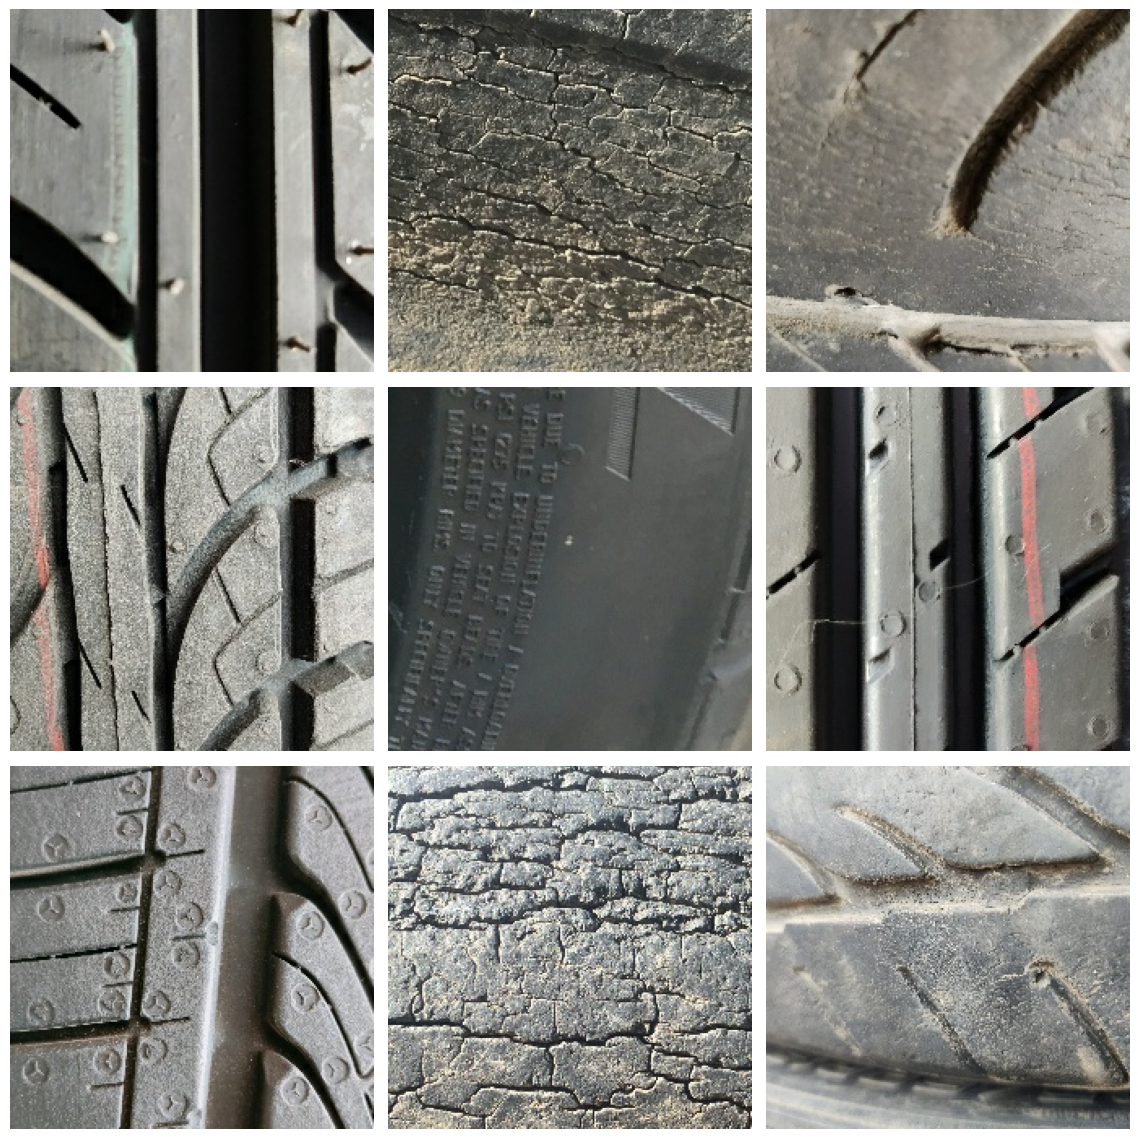

In [ ]:
print(CLR + "Several Image Examples From Validation Dataset:")
efficient_ds = get_dataset_from_tfrecord("valid.tfrecord", "GZIP")
images, labels = list(efficient_ds.take(1).as_numpy_iterator())[0]

plt.figure(figsize=(11.5, 11.5), tight_layout=True, facecolor="white")
for idx, (image, label) in enumerate(zip(images[:9], labels[:9]), start=1):
    plt.subplot(3, 3, idx)
    plt.imshow(image.astype(np.int32))
    plt.axis("off")

plt.show()


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
keras.utils.set_random_seed(42)

inputs = keras.layers.Input(shape=(224, 224, 3))
augmentation = keras.Sequential(
    [
        layers.RandomFlip(),
        layers.RandomRotation(factor=0.2, seed=42),
        layers.RandomContrast(factor=0.4, seed=42),
    ]
)
base_model = tf.keras.applications.EfficientNetB4(include_top=False)
avg = tf.keras.layers.GlobalAveragePooling2D()
output = tf.keras.layers.Dense(1, activation="sigmoid")

augmentation_out = augmentation(inputs)
base_model_out = base_model(augmentation_out)
avg_out = avg(base_model_out)
outputs = output(avg_out)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
import colorama
class ColoramaVerbose(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(
            f"{CLR}Epoch: {MAGENTA}{epoch + 1:02d}{CLR} -",
            f"{CLR}loss: {MAGENTA}{logs['loss']:.5f}{CLR} -",  # type: ignore
            f"{CLR}accuracy: {MAGENTA}{logs['accuracy']:.5f}{CLR} -",  # type: ignore
            f"{CLR}val_loss: {MAGENTA}{logs['val_loss']:.5f}{CLR} -",  # type: ignore
            f"{CLR}val_accuracy: {MAGENTA}{logs['val_accuracy']:.5f}",  # type: ignore
        )
colorama = ColoramaVerbose()

In [ ]:
from colorama import Fore
MAGENTA = '\033[35m'

for layer in base_model.layers:
    layer.trainable = False

optimizer = tf.keras.optimizers.Nadam(learning_rate=0.01)
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
history = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=3,
    callbacks=[colorama],
    verbose=False,
)

2024-12-02 13:22:47.748980: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_2_1/efficientnetb4_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
/opt/conda/lib/python3.10/contextlib.py:153: UserWarning:

Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.




Epoch: 01
 - 
loss: 0.33628
 - 
accuracy: 0.85099
 - 
val_loss: 0.23545
 - 
val_accuracy: 0.88793

Epoch: 02
 - 
loss: 0.24571
 - 
accuracy: 0.89347
 - 
val_loss: 0.26417
 - 
val_accuracy: 0.89224

Epoch: 03
 - 
loss: 0.21108
 - 
accuracy: 0.91133
 - 
val_loss: 0.21078
 - 
val_accuracy: 0.92241


In [ ]:
print(CLR + "The last several layers in EfficientNetB4:", end="\n\n")
for indices in zip(range(400, 420), range(420, len(base_model.layers))):
    for idx in indices:
        print(f"{idx:3}: {base_model.layers[idx].name:30}", end="")
    print()


The last several layers in EfficientNetB4:

400: block6f_expand_bn             420: block6g_se_squeeze            
401: block6f_expand_activation     421: block6g_se_reshape            
402: block6f_dwconv                422: block6g_se_reduce             
403: block6f_bn                    423: block6g_se_expand             
404: block6f_activation            424: block6g_se_excite             
405: block6f_se_squeeze            425: block6g_project_conv          
406: block6f_se_reshape            426: block6g_project_bn            
407: block6f_se_reduce             427: block6g_drop                  
408: block6f_se_expand             428: block6g_add                   
409: block6f_se_excite             429: block6h_expand_conv           
410: block6f_project_conv          430: block6h_expand_bn             
411: block6f_project_bn            431: block6h_expand_activation     
412: block6f_drop                  432: block6h_dwconv                
413: block6f_add                

In [ ]:
for layer in base_model.layers[428:]:
    layer.trainable = True

optimizer = tf.keras.optimizers.Nadam(learning_rate=2e-4)
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
history = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=10,
    callbacks=[colorama],
    verbose=False,
)

2024-12-02 13:23:49.329763: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_2_1/efficientnetb4_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer



Epoch: 01
 - 
loss: 0.28574
 - 
accuracy: 0.87131
 - 
val_loss: 0.21162
 - 
val_accuracy: 0.91810

Epoch: 02
 - 
loss: 0.15255
 - 
accuracy: 0.93227
 - 
val_loss: 0.12422
 - 
val_accuracy: 0.94828

Epoch: 03
 - 
loss: 0.13013
 - 
accuracy: 0.94704
 - 
val_loss: 0.12542
 - 
val_accuracy: 0.94828

Epoch: 04
 - 
loss: 0.09909
 - 
accuracy: 0.96305
 - 
val_loss: 0.11255
 - 
val_accuracy: 0.95259

Epoch: 05
 - 
loss: 0.07104
 - 
accuracy: 0.97475
 - 
val_loss: 0.11592
 - 
val_accuracy: 0.95690

Epoch: 06
 - 
loss: 0.06823
 - 
accuracy: 0.97106
 - 
val_loss: 0.08680
 - 
val_accuracy: 0.96552

Epoch: 07
 - 
loss: 0.05178
 - 
accuracy: 0.97968
 - 
val_loss: 0.09468
 - 
val_accuracy: 0.96552

Epoch: 08
 - 
loss: 0.03872
 - 
accuracy: 0.98645
 - 
val_loss: 0.09265
 - 
val_accuracy: 0.96983

Epoch: 09
 - 
loss: 0.03798
 - 
accuracy: 0.98707
 - 
val_loss: 0.12172
 - 
val_accuracy: 0.96552

Epoch: 10
 - 
loss: 0.04359
 - 
accuracy: 0.98399
 - 
val_loss: 0.11298
 - 
val_accuracy: 0.96121


In [ ]:
from tensorflow.keras.models import save_model

# Save the model in SavedModel format
model.save("/kaggle/working/faultfindy_model.keras")



In [ ]:

loss, acc = model.evaluate(valid_ds, verbose=False)
print(CLR + "Valid Loss:".ljust(20), MAGENTA + f"{loss:.5f}")
print(CLR + "Valid Accuracy:".ljust(20), MAGENTA + f"{acc:.5f}")


Valid Loss:          0.11298

Valid Accuracy:      0.96121


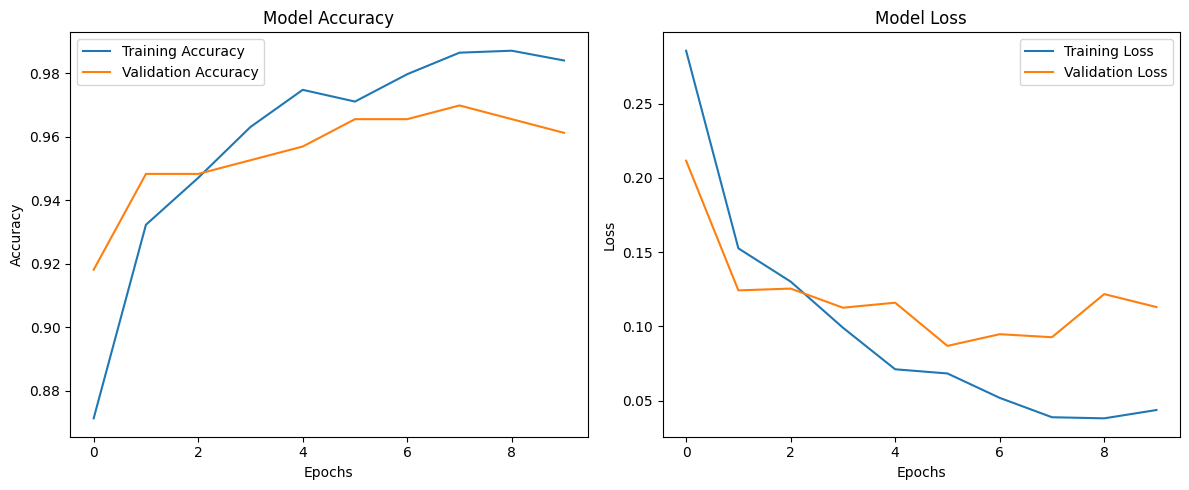

In [ ]:
# Example: Plotting accuracy and loss over epochs

plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()

plt.tight_layout()
plt.show()
